In [1]:
import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('../input/red-wine-dataset/wineQualityReds.csv')
red_wine = red_wine.drop(red_wine.columns[[0]],axis=1)
red_wine.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         1599 non-null   float64
 1   volatile.acidity      1599 non-null   float64
 2   citric.acid           1599 non-null   float64
 3   residual.sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free.sulfur.dioxide   1599 non-null   float64
 6   total.sulfur.dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## creating training and validation splits

In [3]:
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


## scale to [0,1]

In [4]:
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_)/(max_ - min_)
df_valid = (df_valid - min_)/(max_ - min_)

## split features and target

In [5]:
X_train = df_train.drop('quality',axis=1)
X_valid = df_valid.drop('quality',axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1119, 11)
(480, 11)
(1119,)
(480,)


## Neural Network

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    #hidden ReLU units
    layers.Dense(units=512, activation='relu', input_shape=[11]),
    layers.BatchNormalization(),
    
    layers.Dropout(rate=0.3),#Drop out layer to prevent overfitting
    layers.Dense(units=512, activation='relu'),    
    layers.BatchNormalization(),
 
    layers.Dropout(rate=0.3),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
 
    #linear output layer
    layers.Dense(units=1)
])

model.compile(
    optimizer = 'adam',
    loss = 'mae'
)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

## Adding Early Stopping : we can stop training whenever it seems validation loss isnt decreasing

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.001, #min change to count improve
    patience = 20, #least epochs to wait
    restore_best_weights = True
)

## Fit Model

In [8]:
history = model.fit(
    X_train,y_train,
    validation_data = (X_valid,y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [early_stopping],
    verbose = 0
)

2022-01-01 11:18:41.220684: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Min validation loss:0.13889452815055847


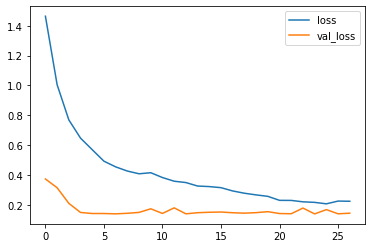

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()

print("Min validation loss:{}".format(history_df['val_loss'].min()))